# Анализ исторических данных о продажах игр для интернет-магазина компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Имеются данные до 2016 года. Представим, что сейчас декабрь 2016 г., и интернет-магазин планирует кампанию на 2017-й.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st

## Знакомство с данными

In [2]:
games = pd.read_csv('games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Обнаружены пропуски в столбцах "Name", "Year_of_Release", "Critic_Score", "User_Score", "Rating". Тип данных в столбце "Year_of_Release" должен быть заменен на "datetime".

## Подготовка данных

### Замена названия столбцов

Приведем данные к нижнему регистру.

In [4]:
games.columns = games.columns.str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Преобразование типов данных

Приведем столбец 'year_of_release' к типу данных "datetime".

In [5]:
games['year_of_release'] = pd.to_datetime(games['year_of_release'],  format='%Y')
games['year_of_release'] = pd.DatetimeIndex(games['year_of_release']).year

Посмотрим на уникальные значения столбца 'user_score'.

In [6]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Значение 'tbd' означает "to be determined". Так как инормационной нагрузки в нашем исследовании данное значение не несет, заменим это значение на NaN.

In [7]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype(float)
games['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

### Обработка пропущенных значений

Найдем пропущенны значения в графе "name".

In [8]:
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Проверим не являются-ли эти строки дубликатами уже имеющихся строк с полными данными.

In [9]:
games[(games['year_of_release'] == 1993) & (games['platform'] == 'GEN')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,Shining Force II,GEN,1993.0,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,Super Street Fighter II,GEN,1993.0,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,Ecco: The Tides of Time,GEN,1993.0,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12264,Streets of Rage 3,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12984,Dynamite Headdy,GEN,1993.0,Platform,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13343,Beyond Oasis,GEN,1993.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Факт того, что эти строки являются дубликатами не подтвердился. Так как само по себе название игры не несет значения для исследования, оставим эти строки.

На этапе знакомства с данными, были обнаружены пропущенные значения в графе 'year_of_release'. Проверим можем-ли мы найти данные о годе выхода игры из названия.

In [10]:
games[games['year_of_release'].isnull()]['name'].unique()

array(['Madden NFL 2004', 'FIFA Soccer 2004',
       'LEGO Batman: The Videogame', 'wwe Smackdown vs. Raw 2006',
       'Space Invaders', 'Rock Band',
       "Frogger's Adventures: Temple of the Frog",
       'LEGO Indiana Jones: The Original Adventures', 'Call of Duty 3',
       'Call of Duty: Black Ops', 'Triple Play 99', 'Adventure', 'Combat',
       'LEGO Harry Potter: Years 5-7', 'NASCAR Thunder 2003',
       'Hitman 2: Silent Assassin', 'Legacy of Kain: Soul Reaver',
       'Donkey Kong Land III', 'Air-Sea Battle', 'Suikoden III',
       'Wheel of Fortune', 'Yakuza 4', 'Namco Museum', 'Rhythm Heaven',
       'The Lord of the Rings: War in the North', 'Madden NFL 07',
       'MLB SlugFest 20-03', 'Shaun White Snowboarding',
       'PES 2009: Pro Evolution Soccer', 'WarioWare: Twisted!',
       'Madden NFL 11', 'Test Drive Unlimited 2',
       'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe',
       'Monster Hunter 2', 'Metal Gear Solid 2: Substance',
       'Advanc

В названии некоторых игр указан год. Можно предположить, что это год выхода игры. "Вытащим" из названия год и подставим его в столец "year of release".

In [11]:
games['date'] = games.name.str.extract('(\d+)')
games['date'] = games['date'].astype(float)
games['date']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
16710       NaN
16711    2007.0
16712       NaN
16713       NaN
16714       8.0
Name: date, Length: 16715, dtype: float64

Сформируем список всех возможных значений годов, принадлежащих к временному интервалу исследования.

In [12]:
games['year_of_release'].min()

1980.0

In [13]:
years = []

for year in range(1980, 2017):
    years.append(year)
for year in range(93, 100):
    years.append(year)

Проверим принадлежат-ли значения годов, "вытащенные" из названий игр значениям в списке "games".

In [14]:
new_df = games.isin({'date': years})
new_df = new_df.rename(columns = {'date' : 'date_id'})
new_df = new_df['date_id']
games = pd.concat((games,new_df), axis=1)
games[games['date_id'] == True]['date'].unique()

array([2015., 2004., 2005., 2007., 2003., 2012., 2008., 2014., 2002.,
       2006., 2009., 2013., 2011., 2010., 2000., 2001.,   99.,   98.,
       2016.,   97.,   96., 1999.,   95.,   94., 1996.])

Оставим только те значения, которые входят во временной интервал исследования.

In [15]:
games['date_id'] = np.where(games['date_id'] == True, games['date'], np.nan)

Заменим пропущенные значения в столбце 'year_of_release' на значения в столбце 'date_id', если соответствующее значение есть.
Строки, в которых остались пропущенные значения удалим, так как информация о годе выхода игры критична для исследования.

In [16]:
games['year_of_release'] = np.where(games['year_of_release'].isnull(), games['date_id'], games['year_of_release'])
games = games[-games['year_of_release'].isnull()]
games = games.drop(['date', 'date_id'], 1)
games['year_of_release'] = games['year_of_release'].astype(int)
games

/var/folders/hs/9m_5jgjj24xctphzgbvlsyhm0000gn/T/ipykernel_13559/3832221473.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  games = games.drop(['date', 'date_id'], 1)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [17]:
games['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983,   99])

Заменим значение "99" на "1999".

In [18]:
games['year_of_release'] = games['year_of_release'].replace(99, 1999)

In [19]:
games = games[-games['year_of_release'].isnull()]

Заменим пропущенные значения в столбце "Rating" на "Not determined", чтобы в дальнейшем проанализировать влияние отсутствия рейтинга на продажи.

In [20]:
games['rating'] = games['rating'].fillna('Not determined')

### Подсчет суммарных продаж во всех регионах

In [21]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## Исследовательский анализ данных

### Распределение выпущенных игр по годам

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, '1980'),
  Text(1, 0, '1981'),
  Text(2, 0, '1982'),
  Text(3, 0, '1983'),
  Text(4, 0, '1984'),
  Text(5, 0, '1985'),
  Text(6, 0, '1986'),
  Text(7, 0, '1987'),
  Text(8, 0, '1988'),
  Text(9, 0, '1989'),
  Text(10, 0, '1990'),
  Text(11, 0, '1991'),
  Text(12, 0, '1992'),
  Text(13, 0, '1993'),
  Text(14, 0, '1994'),
  Text(15, 0, '1995'),
  Text(16, 0, '1996'),
  Text(17, 0, '1997'),
  Text(18, 0, '1998'),
  Text(19, 0, '1999'),
  Text(20, 0, '2000'),
  Text(21, 0, '2001'),
  Text(22, 0, '2002'),
  Text(23, 0, '2003'),
  Text(24, 0, '2004'),
  Text(25, 0, '2005'),
  Text(26, 0, '2006'),
  Text(27, 0, '2007'),
  Text(28, 0, '2008'),
  Text(29, 0, '2009'),
  Text(30, 0, '2010'),
  Text(31, 0, '2011'),
  Text(32, 0, '2012'),
  Text(33, 0, '2013'),
  Text(34, 0, '2014'),
  Text(35, 0, '2015'),
  Text(3

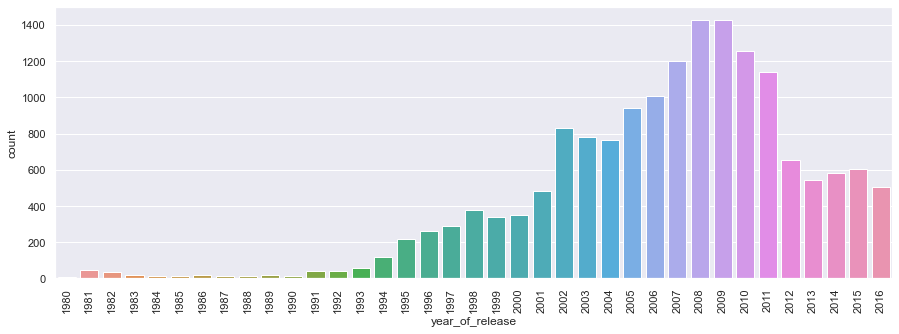

In [22]:
games_grouped = games.groupby(games['year_of_release'])['name'].count().reset_index()
games_grouped = games_grouped.rename(columns = {'name' : 'count'})
sns.set(rc={'figure.figsize':(15, 5)})
sns.barplot(x = 'year_of_release', y = 'count', data = games_grouped)
plt.xticks(rotation=90)

Количество выспускаемых в год игр резко сократилось в 2012 году.

### Распределение выпущенных игр по платформам

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

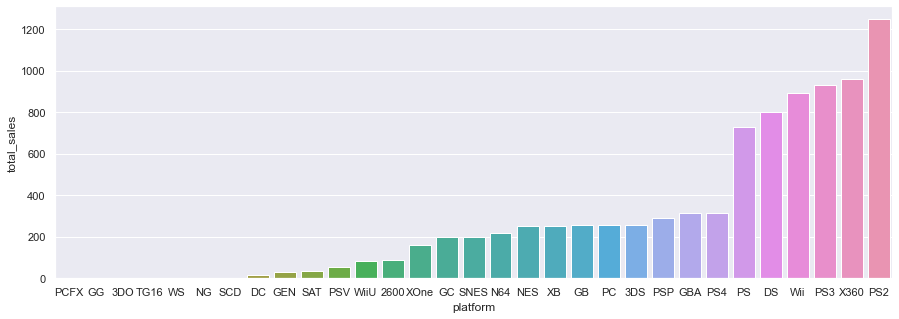

In [23]:
games_platform_grouped = games.groupby('platform')['total_sales'].sum().reset_index()
games_platform_grouped = games_platform_grouped.sort_values(by = 'total_sales')
sns.set(rc={'figure.figsize':(15, 5)})
sns.barplot(x = 'platform', y = 'total_sales', data = games_platform_grouped)

In [24]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Отберем 6 наиболее популярных платформ.

In [25]:
games_popular_platforms = games[games['platform'].isin(('PS', 'X360', 'Wii', 'PS3', 'DS', 'PS2'))]

Проверим характерный "срок жизни" платформ. Посмотрим на то, сколько игр продавалось на каждой популярной платформе в тот или иной год.

In [26]:
games_popular_platforms_pivot = games_popular_platforms.pivot_table(index = 'year_of_release', 
                                                                    columns = 'platform', 
                                                                    values = 'total_sales', 
                                                                    aggfunc = 'sum')
games_popular_platforms_pivot = games_popular_platforms_pivot.fillna(0)
games_popular_platforms_pivot

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1985,0.02,0.00,0.00,0.00,0.00,0.00
1994,0.00,6.03,0.00,0.00,0.00,0.00
1995,0.00,35.96,0.00,0.00,0.00,0.00
1996,0.00,94.70,0.00,0.00,0.00,0.00
1997,0.00,136.17,0.00,0.00,0.00,0.00
1998,0.00,169.49,0.00,0.00,0.00,0.00
1999,0.00,145.99,0.00,0.00,0.00,0.00
2000,0.00,96.37,39.17,0.00,0.00,0.00
2001,0.00,35.59,166.43,0.00,0.00,0.00


array([<AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>], dtype=object)

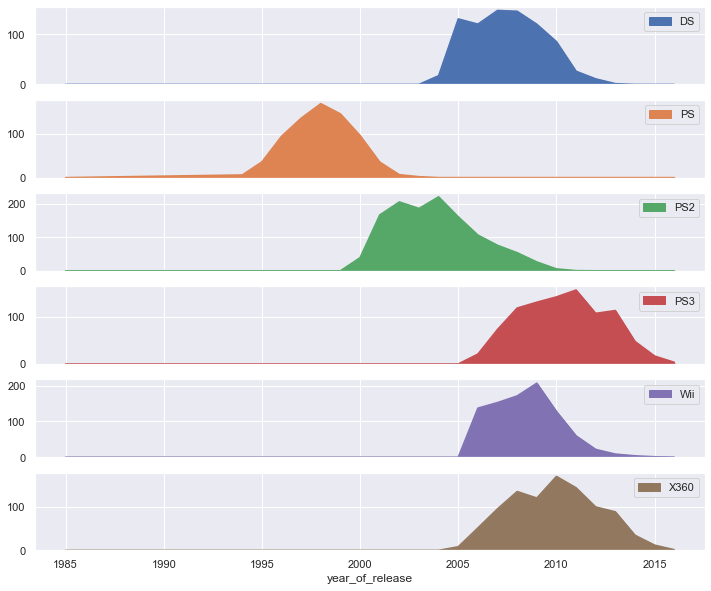

In [27]:
games_popular_platforms_pivot.plot.area(figsize=(12, 10), subplots=True)

На графике можно видеть, что в среднем популярные платформы "живут" 8-11 лет. Проверим эти цифры: найдем срок жизни каждой популярной платформы и найдем медиану значений.

In [28]:
games_grouped = games_popular_platforms.groupby('platform')['year_of_release'].max() - games_popular_platforms.groupby('platform')['year_of_release'].min()
games_grouped = games_grouped.reset_index()
games_grouped.sort_values('year_of_release', ascending = False)

,platform,year_of_release
0,DS,28
2,PS2,11
5,X360,11
3,PS3,10
4,Wii,10
1,PS,9


Срок жизни платформы 'DS' большой из-за выброса, который был найден ранее на этапе построения сводной таблицы - есть одна игра 1985 года, хотя остальные игры на этой платформе стали появляться в 2004 году. Найдем и уберем выброс.

In [29]:
games[games['platform'] == 'DS'].sort_values('year_of_release').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.0,NaN,NaN,Not determined,0.02
13463,Cocoto Kart Racer,DS,2004,Racing,0.04,0.00,0.00,0.0,NaN,NaN,E,0.04
11517,Kenshuui Tendo Dokuta,DS,2004,Simulation,0.00,0.00,0.08,0.0,NaN,NaN,Not determined,0.08
4421,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.0,NaN,NaN,Not determined,0.43
7902,Daigasso! Band Brothers,DS,2004,Misc,0.00,0.00,0.19,0.0,NaN,NaN,Not determined,0.19


In [30]:
games = games.drop([15957])
games = games.reset_index()

In [31]:
games_grouped['year_of_release'].median()

10.5

In [32]:
games_grouped['year_of_release'].mean()

13.166666666666666

Медианный срок жизни платформы - 10,5 лет. Средний - 13 лет. Однако период исследования игр за последние 10-13 лет выглядит слишком большим, учитывая, что рынок за этот период сильно менялся дважды - после 2005 года - резкое увеличение количества выпущенных за год игр, начиная с 2012 года - резкое сокращение. Оставим в датасете данные с 2012 года.

In [33]:
games = games[games['year_of_release'] >= 2012]

### Выявление актуальных платформ

Посмотрим на то сколько игр продавалось на каждой платформе в тот или иной год.

In [34]:
games_pivot = games.pivot_table(index = 'year_of_release', 
                                columns = 'platform', 
                                values = 'total_sales', 
                                aggfunc = 'sum')
games_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.73,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


array([<AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>,
       <AxesSubplot:xlabel='year_of_release'>], dtype=object)

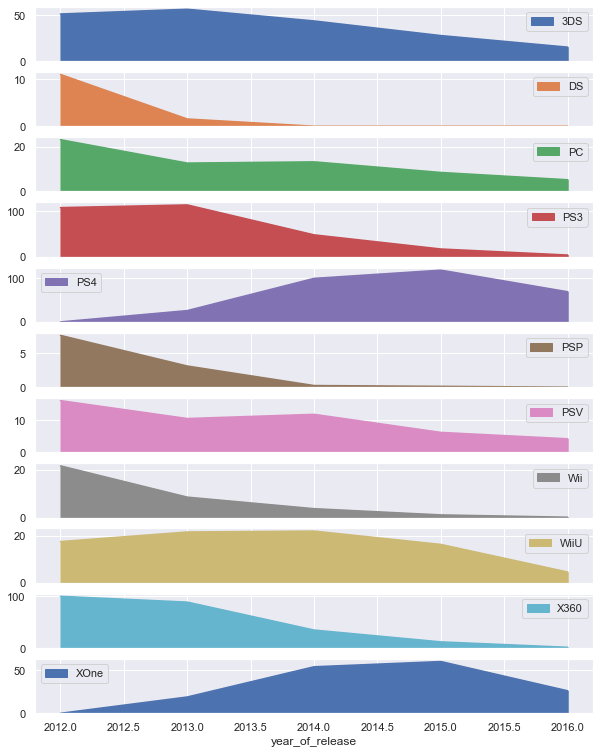

In [35]:
games_pivot.plot.area(figsize=(10, 13), subplots=True)

На графике видно, что все актуальные платформы уже пережили свой пик по продажам выпускающихся на них игр. Перспективных платформ не много: только PS4, 3DS и XOne еще имеют хорошие показатели. Также платформа PC не сильно подвержена колебаниям из-за долгого срока жизни платформы - игры на компьютере выходили и будут выходить, скорее всего всегда. Видимо стоит ожидать появления новой платформы в ближайшие годы.

### Box-plot

Построим график «box-plot» по глобальным продажам игр в разбивке по наиболее перспективных платформам для того, чтобы выявить несимметрично распределенные продажи и выборсы.

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

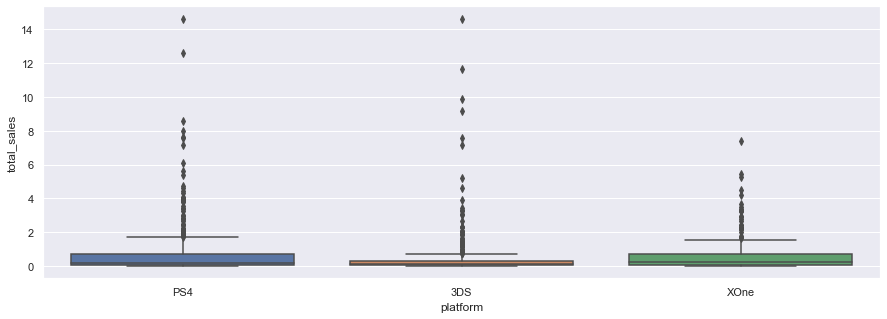

In [36]:
games_perspective_platforms = games[games['platform'].isin(('PS4', '3DS', 'XOne'))]
sns.boxplot(x = 'platform', y = 'total_sales', data = games_perspective_platforms)

Большинство значений так бизко находятся к нулю, что невозможно разобрать графики, из чего можно уже сделать вывод, что больгинство игр почти не продаются - они очень непопулярны. Уберем из выборки самые непопулярные игры.

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

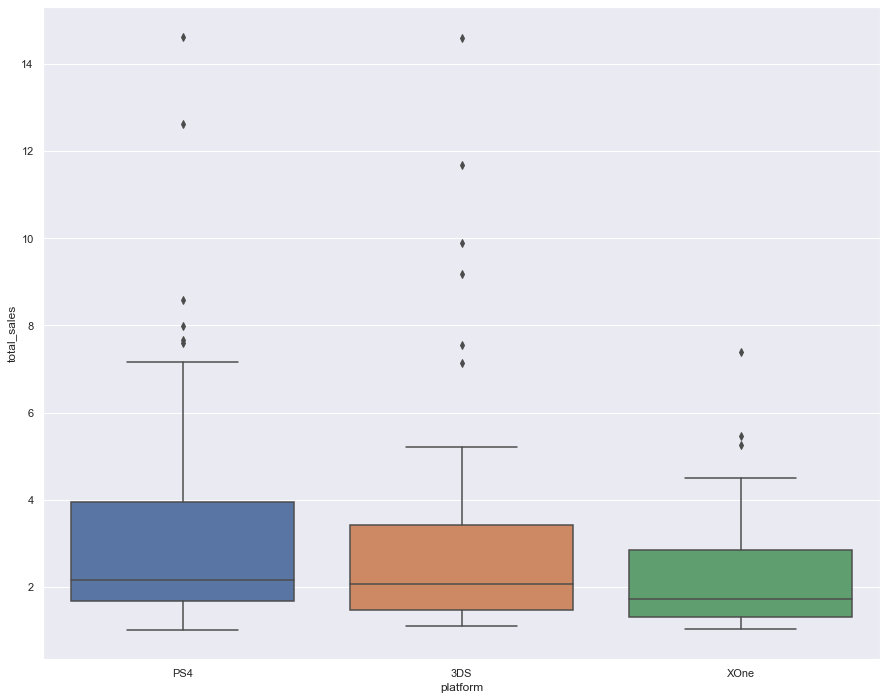

In [37]:
sns.set(rc={'figure.figsize':(15, 12)})
games_perspective_platforms = games_perspective_platforms[games_perspective_platforms['total_sales'] > 1]
sns.boxplot(x = 'platform', y = 'total_sales', data = games_perspective_platforms)

Убрав самые минимальные значения, становится видно, что количество игр с продажами меньше медианной все равно осталось больше у всех выбранных платформ, при этом на платформах "PS4", "3DS" встречаются самые популярные игры, продажи которых заметно больше остальных игр на всех выбранных платформах платформах. На фоне вышеуказанных платформ, продажи игр на платформе "XOne" наименее разбросаны, следовательно объем продаж будущих игр на этой платформе более предсказуем. Медианные значения всех трех платформ очень близки.

### Влияние отзывов пользователей и критиков на продажи игр

Возьмем одну из самых популярных платформ '3DS'. На ее примере посмотрим корреляцию отзывов и продаж. Сначала проверим кореллируют-ли продажи с отзывами критиков.

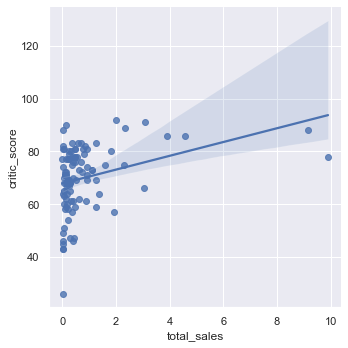

In [38]:
games_ps2 = games[games['platform'] == '3DS']
sns.lmplot(data = games_ps2, x = 'total_sales', y = 'critic_score')

Затем проверим кореллируют-ли продажи с отзывами пользователей.

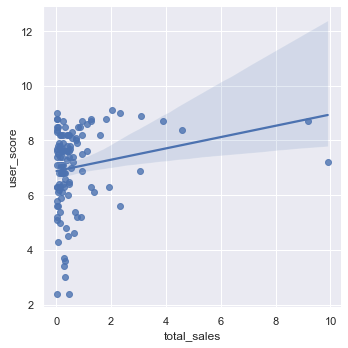

In [39]:
sns.lmplot(data = games_ps2, x = 'total_sales', y = 'user_score')

In [40]:
games_ps2[['critic_score', 'user_score', 'total_sales']].corr()['total_sales']

critic_score    0.320803
user_score      0.197583
total_sales     1.000000
Name: total_sales, dtype: float64

Продажи кореллируют с отзывами критиков сильнее, чем с отзывами пользователей, однако все равно слабо - процент корреляции - всего 32%.

Соотнесем выводы с продажами игр на всех платформах.

<AxesSubplot:xlabel='total_sales', ylabel='critic_score'>

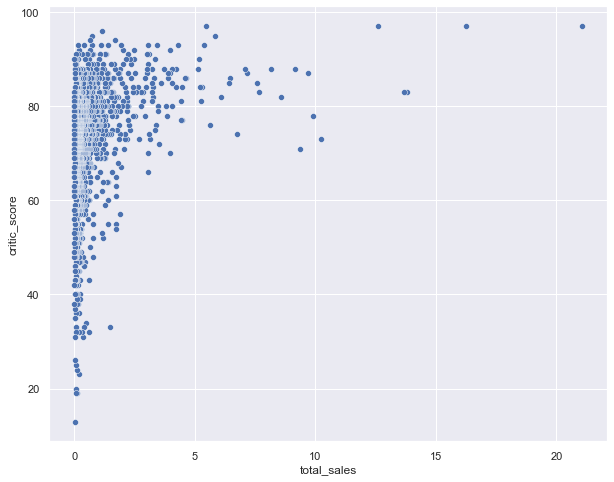

In [41]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.scatterplot(data = games, x = 'total_sales', y = 'critic_score')

<AxesSubplot:xlabel='total_sales', ylabel='user_score'>

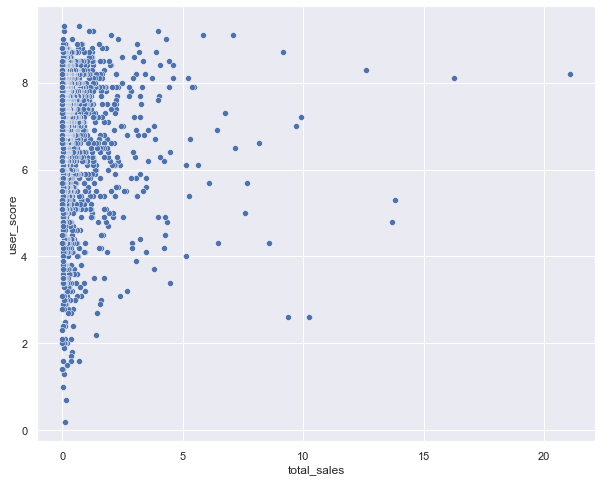

In [42]:
sns.scatterplot(data = games, x = 'total_sales', y = 'user_score')

In [43]:
games[['critic_score', 'user_score', 'total_sales']].corr()['total_sales']

critic_score    0.307823
user_score      0.004225
total_sales     1.000000
Name: total_sales, dtype: float64

Результаты повторились и на уровне общих продаж по всем платформам. При формировании стратегии продаж, можно не принимать во внимание отзывы критиков и пользователей - хорошо оцененная игра может продаваться как хорошо, так и плохо.

### Распределение игр по жанрам

In [44]:
games_genre = games.groupby('genre')['total_sales'].mean()
games_genre = games_genre.sort_values(ascending = False).reset_index()
games_genre

,genre,total_sales
0,Shooter,1.296723
1,Platform,0.717647
2,Sports,0.675634
3,Role-Playing,0.521081
4,Racing,0.465217
5,Misc,0.442917
6,Simulation,0.439000
7,Action,0.427781
8,Fighting,0.408165
9,Strategy,0.187887


<AxesSubplot:xlabel='genre', ylabel='total_sales'>

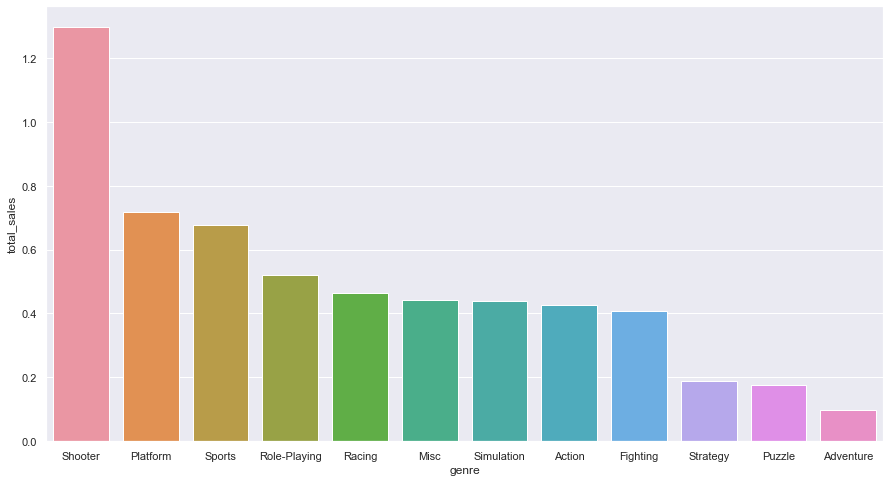

In [45]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.barplot(data = games_genre, x = 'genre', y = 'total_sales')

Самый прибыльный жанр: "Shooter", продажи от игр остальных жанров расположены по убыванию без значительных скачков.

## Портрет пользователя каждого региона

### Самые популярные платформы в регионах

In [46]:
games_top_platforms_in_regions = games.pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
games_top_platforms_in_regions['eu_sales'] = games_top_platforms_in_regions['eu_sales']/games_top_platforms_in_regions['eu_sales'].sum()
games_top_platforms_in_regions['jp_sales'] = games_top_platforms_in_regions['jp_sales']/games_top_platforms_in_regions['jp_sales'].sum()
games_top_platforms_in_regions['na_sales'] = games_top_platforms_in_regions['na_sales']/games_top_platforms_in_regions['na_sales'].sum()
games_top_platforms_in_regions = games_top_platforms_in_regions.round(2)
games_top_platforms_in_regions.sort_values(by = 'eu_sales', ascending = False)

,eu_sales,jp_sales,na_sales
platform,,,
PS4,0.28,0.08,0.18
PS3,0.21,0.18,0.17
X360,0.15,0.01,0.24
XOne,0.10,0.00,0.16
3DS,0.08,0.46,0.09
PC,0.07,0.00,0.03
WiiU,0.05,0.07,0.06
PSV,0.02,0.11,0.02
Wii,0.02,0.02,0.03


В северной Америке и Европе предпочтения по платформам сравнительно похожи. Из заметных различий - X360, XOne сильно популярнее в Северной Америке, чем в Европе. На PS4 гораздо чаще играют в Европе, чем в Америке. 

In [47]:
games_top_platforms_in_regions.sort_values(by = 'jp_sales', ascending = False)

,eu_sales,jp_sales,na_sales
platform,,,
3DS,0.08,0.46,0.09
PS3,0.21,0.18,0.17
PSV,0.02,0.11,0.02
PS4,0.28,0.08,0.18
WiiU,0.05,0.07,0.06
PSP,0.00,0.05,0.00
DS,0.01,0.02,0.01
Wii,0.02,0.02,0.03
X360,0.15,0.01,0.24


На Японском рынке лидирует платформа 3DS, которая не популярна в Европе и Северной Америке, зато сильно проигрывает платформа X360, которая очень популярна в Европе, и еще более популярна в Северной Америке.

#### Самые популярные жанры в регионах

In [48]:
games_top_genres_in_regions = games.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')

In [49]:
games_top_genres_in_regions['eu_sales'] = games_top_genres_in_regions['eu_sales']/games_top_genres_in_regions['eu_sales'].sum()
games_top_genres_in_regions['jp_sales'] = games_top_genres_in_regions['jp_sales']/games_top_genres_in_regions['jp_sales'].sum()
games_top_genres_in_regions['na_sales'] = games_top_genres_in_regions['na_sales']/games_top_genres_in_regions['na_sales'].sum()
games_top_genres_in_regions = games_top_genres_in_regions.round(2)
games_top_genres_in_regions.sort_values(by = 'eu_sales', ascending = False)

,eu_sales,jp_sales,na_sales
genre,,,
Action,0.31,0.27,0.30
Shooter,0.22,0.05,0.24
Sports,0.14,0.04,0.14
Role-Playing,0.10,0.34,0.11
Misc,0.05,0.07,0.06
Racing,0.05,0.01,0.03
Platform,0.04,0.04,0.04
Simulation,0.03,0.05,0.01
Adventure,0.02,0.04,0.02


Предпочтения пользователей в Европе и Америке также похожи - больше всего пользователи любят жанр Action. Остальные жарны занимают примерно одинаковую долю на обоих рынках.

In [50]:
games_top_genres_in_regions.sort_values(by = 'jp_sales', ascending = False).head()

,eu_sales,jp_sales,na_sales
genre,,,
Role-Playing,0.10,0.34,0.11
Action,0.31,0.27,0.30
Misc,0.05,0.07,0.06
Fighting,0.02,0.05,0.03
Shooter,0.22,0.05,0.24


На Японском рынке самую болшую долю занимают игры в жанре ролевой игры, что совсем не характерно для рынков Европы и Северной Америки, где этот жанр занимает только пятую позицию по популярности. Остальные места распеределены по популярности примерно похожим с остальными рынками образом.

#### Влияние рейтинга ESRB на продажи в регионах

In [51]:
games_esrb_rating = games.pivot_table(index = 'rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
games_esrb_rating['na_sales'] = games_esrb_rating['na_sales']/games_esrb_rating['na_sales'].sum()
games_esrb_rating['eu_sales'] = games_esrb_rating['eu_sales']/games_esrb_rating['eu_sales'].sum()
games_esrb_rating['jp_sales'] = games_esrb_rating['jp_sales']/games_esrb_rating['jp_sales'].sum()
games_esrb_rating

,eu_sales,jp_sales,na_sales
rating,,,
E,0.222908,0.147108,0.193510
E10+,0.109196,0.042528,0.128081
M,0.383004,0.110084,0.391909
Not determined,0.180448,0.565168,0.174797
T,0.104443,0.135113,0.111703


array([<AxesSubplot:title={'center':'eu_sales'}, xlabel='rating'>,
       <AxesSubplot:title={'center':'jp_sales'}, xlabel='rating'>,
       <AxesSubplot:title={'center':'na_sales'}, xlabel='rating'>],
      dtype=object)

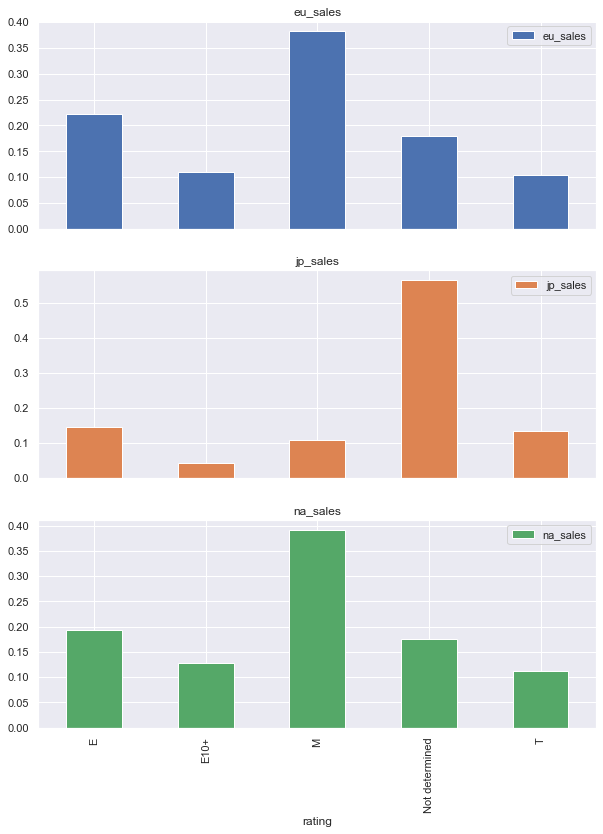

In [52]:
games_esrb_rating.plot.bar(figsize=(10, 13), subplots=True)

Самым заметным различием между рынками является то, что в Японии почти 50% продаж приходятся на игры без рейтинга ESRB. По сравнению с рынками Европы и Северной Америки - это очень много. В Европе и Америке доля продаж игр без рейтинга ESRB составляет всего лишь 17-18%. Вероятно это происходит по причине того, что в Японии имеется местная система оценки игр "EOCS", и рейтинги играм присваивает эта организация.

Распеределение продаж в зависимости от рейтинга выглядит похожим образом в зависимости от региона. Значимо выделяется только доля продаж игр с рейтингом "М" в Японии - в 2 раза меньше, чем в Европе и Северной Америке.

Вывод: Рынки Америки и Европы похожи друг на друга вне повердения пользователей. Рынок Японии отличается - у японских пользователей первые места в рейтингах занимают популярны другие платформы (3DS), другие жанры (Role playing)
Также в Японии гораздо менее популярны игры, оцененные ESRB, как для взрослых, однако гораздо популярнее игры без рейтинга ESRB, вероятно по причине того, что в Японии имеется местная система оценки игр "EOCS", и рейтинги играм присваивает эта ориганизация.

## Проверка гипотез. Статистический анализ данных

### Сравнение пользовательских рейтингов платформ Xbox One и PC;

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [53]:
games_xbox = games[games['platform'] == 'XOne']
games_xbox = games_xbox['user_score'].dropna()
games_pc = games[games['platform'] == 'PC']
games_pc = games_pc['user_score'].dropna()

/Users/demo/PycharmProjects/Statistical project/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/demo/PycharmProjects/Statistical project/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='user_score', ylabel='Density'>

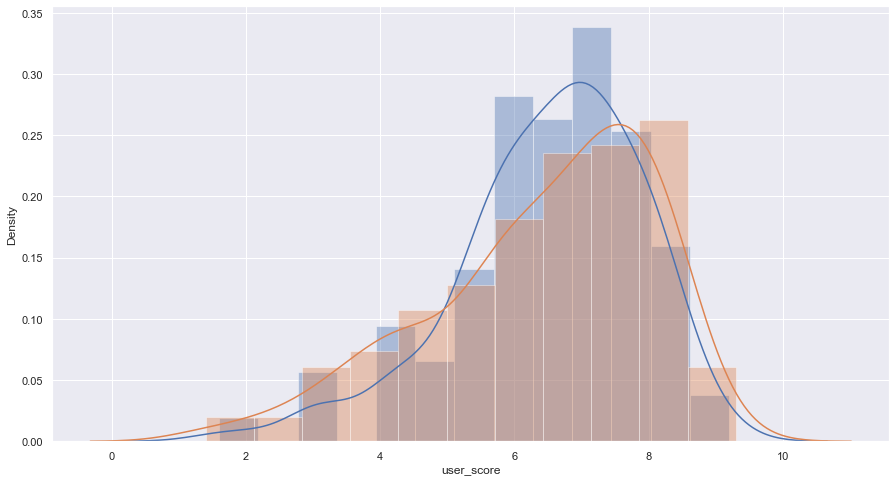

In [54]:
sns.distplot(games_xbox)
sns.distplot(games_pc)

In [55]:
alpha = 0.05

results = st.ttest_ind(games_xbox, games_pc)

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5970211251516371
Не получилось отвергнуть нулевую гипотезу


Вывод: статистически значимых различий в пользовательских рейтингах между платформами Xbox One и PC не обнаружено.

### Сравнение пользовательских рейтингов жанров Action и Sports

Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») отличаются.

In [56]:
games_action = games[games['genre'] == 'Action']
games_action = games_action['user_score'].dropna()
games_sports = games[games['genre'] == 'Sports']
games_sports = games_sports['user_score'].dropna()

/Users/demo/PycharmProjects/Statistical project/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/demo/PycharmProjects/Statistical project/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='user_score', ylabel='Density'>

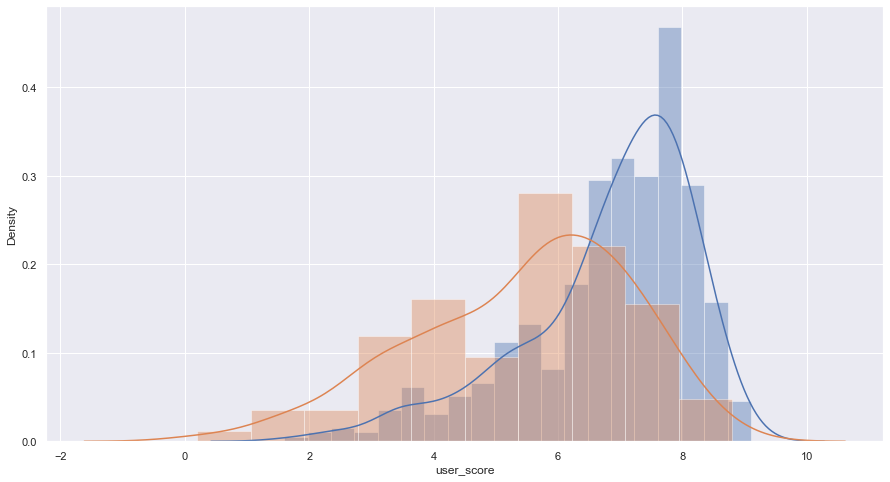

In [57]:
sns.distplot(games_action)
sns.distplot(games_sports)

In [58]:
alpha = 0.05

results = st.ttest_ind(games_action, games_sports)

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8733525657180856e-26
Отвергаем нулевую гипотезу


In [59]:
games_action.mean() > games_sports.mean()

True

/Users/demo/PycharmProjects/Statistical project/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_score'>

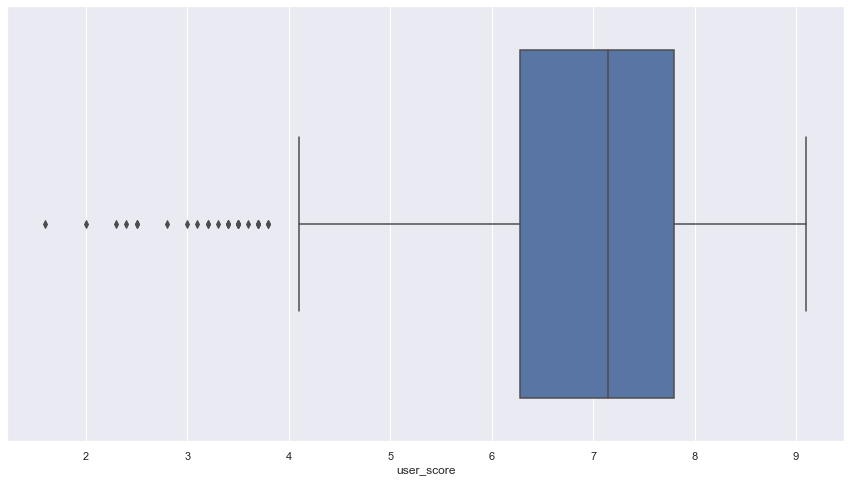

In [60]:
sns.boxplot(games_action)

/Users/demo/PycharmProjects/Statistical project/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_score'>

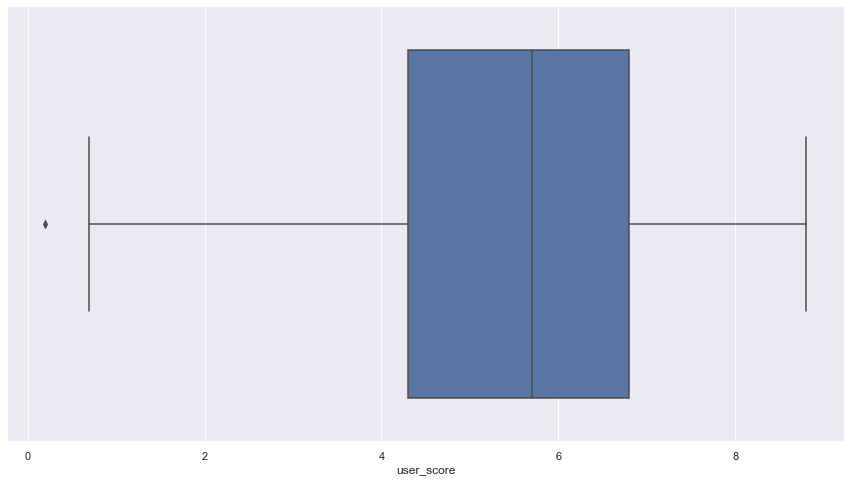

In [61]:
sns.boxplot(games_sports)

Вывод: статистически значимые различия в пользовательских рейтингах между жанрами "Action" и "Sports" обнаружены. Среднее значение рейтинга жанра "Action" выше.

## Вывод

Можно ожидать появления в 2017 году новой игровой платформы, так как все популярные на данный момент платформы пережили пик своей популярности, и количество игр, выходящих на платформах падает. Из нынешних платформ наиболее перспективны платформы  PS4, XOne и 3DS, так как на них еще выпускается достаточно большое количество игр.

На рынке Японии, нужно учитывать местную специфику поведения пользователей - японским пользователям значительно больше нравится жанр "Role Playing", чем пользователям из Северной Америки и Европы. Также японские польователи предпочитают платформу 3DS, которая не популярна в Европе и Северной Америке и не так активно покупают игры, оцененные ESRB. Вероятно это происходит по причине того, что в Японии имеется местная система оценки игр "EOCS", и рейтинги играм присваивает эта организация - поэтому необходимо иметь базу этих рейтингов, чтобы делать однозначные выводы о поведении японских пользователей в зависимсти от возрастной категории игры.

Топ платформы в Японии: 3DS и PS3. Топ жанры: "Role Playing", "Action"

Поведение пользователей из Европы из Северной Америки и Европы похоже:
Топ платформы в Европе и Америке: PS4, PS3, X360. Топ жанры: "Action", "Shooter", Топ рейтинги ESRB: "M", "E".

Рейтинги пользователей и критиков имеют некоторое влияние на доход от игры, но хорошо оцененная игра может продаваться как хорошо, так и плохо. Рейтинг новых игр не должен быть определяющим фактором при составлении прогноза продаж на год.
